# Fluctuation Analyses

This notebook covers 'fluctuation' analyses, such as the Hurst exponent and Detrended Fluctuation Analysis (DFA). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined
from neurodsp.aperiodic import compute_fluctuations
from neurodsp.utils import set_random_seed

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims
from apm.wrappers import hurst_wrapper, dfa_wrapper
from apm.plts import plot_lines
from apm.plts.settings import AP_COL, COMB_COL
from apm.sim.settings import FS, SIM_PARAMS_AP, SIM_PARAMS_COMB, EXPS, FREQS, POWS, N_SIMS, EXP
from apm.sim.examples import SIG_AP, SIG_KN, SIG_OSC, SIG_COMB

## Helper Functions

In [3]:
# Note: these are in progress to being added to NeuroDSP
def convert_exponent_alpha(exp):
    """Convert the powerlaw exponent to expecteed DFA alpha value."""
    
    return (-exp + 1) / 2

def convert_alpha_exponent(alpha):
    """Convert the DFA alpha value to expected powerlaw exponent."""
    
    return -2 * alpha + 1

## Settings

In [4]:
# Set the random seed
set_random_seed(111)

In [5]:
# Notebook settings
SAVE_FIG = False

## Hurst Exponent

The Hurst exponent is a method for measuring the self-similarity of a signal.

In [6]:
# Hurst settings
hurst_params = {
    'fs' : FS,
    'n_scales' : 10,
    'min_scale' : 0.1,
    'max_scale' : 2.0
}

### Hurst Exponent on Example Signals

Compute the Hurst exponent on some example signals.

In [8]:
# Check the calculated hurst exponent, and the expected value
print('Computed Hurst signals:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(hurst_wrapper(SIG_AP, **hurst_params), 0.5))
print('  osc:      \t {:6.4f}'.format(hurst_wrapper(SIG_OSC, **hurst_params)))
print('  combined: \t {:1.4f}'.format(hurst_wrapper(SIG_COMB, **hurst_params)))
print('  knee:     \t {:1.4f}'.format(hurst_wrapper(SIG_KN, **hurst_params)))

Computed Hurst signals:
  powerlaw: 	 0.4895 	 0.50
  osc:      	 -0.0033
  combined: 	 0.8693
  knee:     	 0.5908


### Hurst Exponent: Aperiodic Variations

In [9]:
# Run a set of simulations, calculating Hurst across exponents
hurst_sims_exp = run_sims(sim_powerlaw, SIM_PARAMS_AP, hurst_wrapper, hurst_params,
                          update='update_exp', values=EXPS, n_sims=N_SIMS)

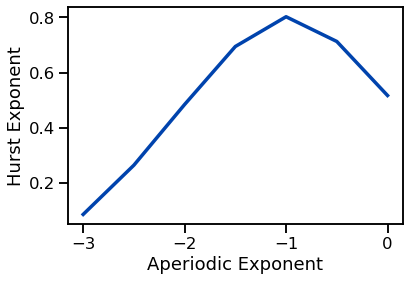

In [10]:
# Plot Hurst measures
plot_lines(EXPS, hurst_sims_exp, color=AP_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='Hurst Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='hurst_exp', file_path='hurst')

In [11]:
# Run a set of simulations, calculating Hurst across exponents, with an oscillation
hurst_sims_comb = run_sims(sim_combined, SIM_PARAMS_COMB, hurst_wrapper, hurst_params,
                           update='update_comb_exp', values=EXPS, n_sims=N_SIMS)

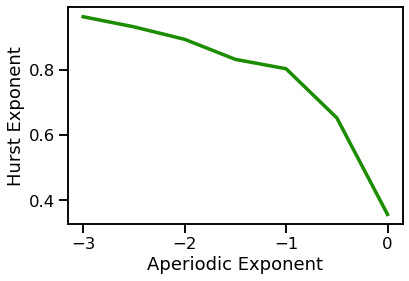

In [12]:
# Plot Hurst measures
plot_lines(EXPS, hurst_sims_comb, color=COMB_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='Hurst Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='hurst_comb', file_path='hurst')

#### Plot Aperiodic & Combined Together

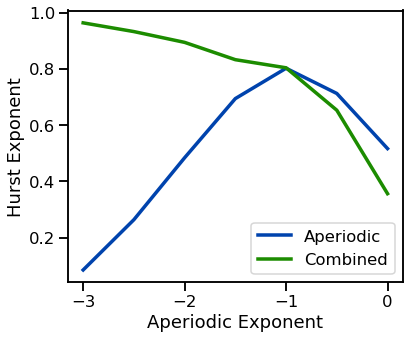

In [14]:
# Plot Hurst measures
plot_lines(figsize=(6, 5))
plot_lines(EXPS, hurst_sims_exp, color=AP_COL, label='Aperiodic')
plot_lines(EXPS, hurst_sims_comb, color=COMB_COL, label='Combined')
plot_lines(xlabel='Aperiodic Exponent', ylabel='Hurst Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='hurst_both', file_path='hurst')

### Hurst Exponent: Periodic Variations

In [16]:
# Run a set of simulations, calculating Hurst Exponent across oscillation frequencies
hurst_sims_freq = run_sims(sim_combined, SIM_PARAMS_COMB, hurst_wrapper, hurst_params,
                           update='update_freq', values=FREQS, n_sims=N_SIMS)

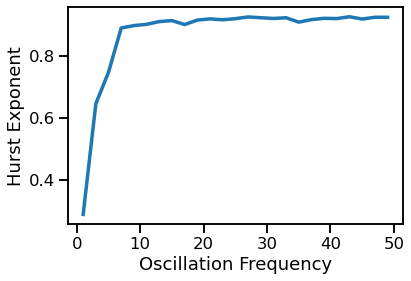

In [17]:
# Plot Hurst measures across oscillation frequency values
plot_lines(FREQS, hurst_sims_freq)
plot_lines(xlabel='Oscillation Frequency', ylabel='Hurst Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='hurst_osc_freq', file_path='hurst')

In [18]:
# Run a set of simulations, calculating Hurst across oscillation power
hurst_sims_pow = run_sims(sim_combined, SIM_PARAMS_COMB, hurst_wrapper, hurst_params,
                          update='update_pow', values=POWS, n_sims=N_SIMS)

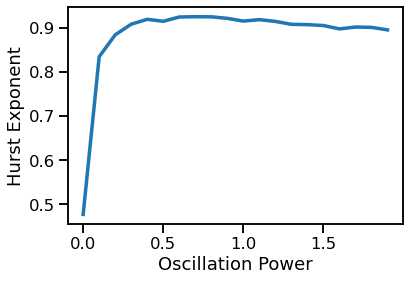

In [19]:
# Plot Hurst measures across oscillation power values
plot_lines(POWS, hurst_sims_pow)
plot_lines(xlabel='Oscillation Power', ylabel='Hurst Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='hurst_osc_power', file_path='hurst')

## Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

In this notebook, we will explore:
- applying DFA to neural time signals
- how DFA measures relate to different properties of neural time series
- compare DFA measures to other measures of 1/f. 

### Notes
- It looks like the expected relationship between DFA & 1/f appears to be true in the range of $\chi$ from -3 to 0. 
    - It seems like it breaks down with exponent of less than -3
    - It also doesn't seem to hold for exponents > 0
- The presence of an oscillations decreases measures DFA
    - Increasing the frequency of the oscillation further decreases measured DFA
    - Increasing the relative power of the oscillation further decreases measured DFA
- It would appear that given a combined signal, the measured DFA is upper-bound at the expected DFA given the exponent

### Settings

In [20]:
# DFA settings
dfa_params = {
    'fs' : FS,
    'n_scales' : 10,
    'min_scale' : 0.1,
    'max_scale' : 2.0,
    'deg' : 1
}

### DFA on Example Signals

In [22]:
# Check the computed DFA exponents on some example signals
print('DFA exponents:')
print('  powerlaw: \t {:1.4f} \t {:1.2f}'.format(dfa_wrapper(SIG_AP, **dfa_params),
                                                 convert_exponent_alpha(EXP)))
print('  osc:      \t {:1.4f}'.format(dfa_wrapper(SIG_OSC, **dfa_params)))
print('  combined: \t {:1.4f}'.format(dfa_wrapper(SIG_COMB, **dfa_params)))
print('  knee:     \t {:1.4f}'.format(dfa_wrapper(SIG_KN, **dfa_params)))

DFA exponents:
  powerlaw: 	 1.4890 	 1.50
  osc:      	 0.0078
  combined: 	 0.9527
  knee:     	 0.6359


### DFA Simulations: Aperiodic Variations

In [23]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected = [convert_exponent_alpha(exp) for exp in EXPS]

In [24]:
# Run a set of simulations, calculating DFA across exponents
dfa_sims_exp = run_sims(sim_powerlaw, SIM_PARAMS_AP, dfa_wrapper, dfa_params,
                        update='update_exp', values=EXPS, n_sims=N_SIMS)

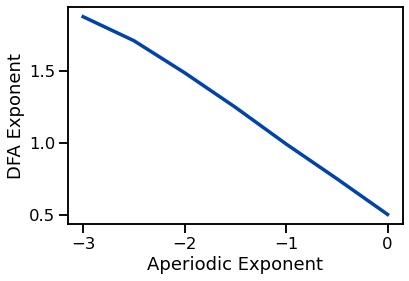

In [25]:
# Plot approximate entropy measures across exponent values
plot_lines(EXPS, dfa_sims_exp, color=AP_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_exp', file_path='dfa')

In [26]:
# Run a set of simulations, calculating DFA across exponents, with an oscillation
dfa_sims_comb = run_sims(sim_combined, SIM_PARAMS_COMB, dfa_wrapper, dfa_params,
                         update='update_comb_exp', values=EXPS, n_sims=N_SIMS)

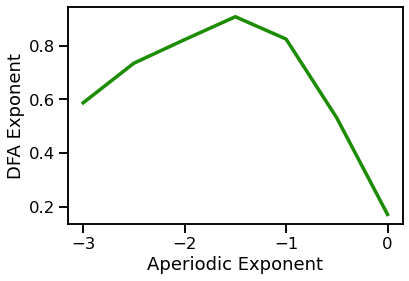

In [27]:
# Plot approximate entropy measures across exponent values
plot_lines(EXPS, dfa_sims_comb, color=COMB_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_comb', file_path='dfa')

#### Plot Aperiodic & Combined Together

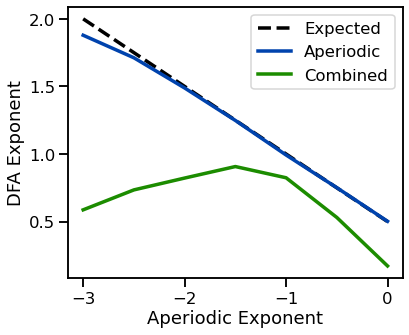

In [28]:
# Plot DFA measures
plot_lines(figsize=(6, 5))
plot_lines(EXPS, expected, color='k', linestyle='--', label='Expected');
plot_lines(EXPS, dfa_sims_exp, color=AP_COL, label='Aperiodic')
plot_lines(EXPS, dfa_sims_comb, color=COMB_COL, label='Combined')
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_both', file_path='dfa')

### DFA Simulations: Periodic Variations

In [29]:
# Run a set of simulations, calculating DFA across oscillation frequencies
dfa_sims_freq = run_sims(sim_combined, SIM_PARAMS_COMB, dfa_wrapper, dfa_params,
                        update='update_freq', values=FREQS, n_sims=N_SIMS)

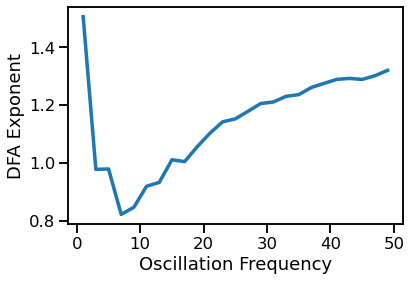

In [30]:
# Plot DFA measures across oscillation frequency values
plot_lines(FREQS, dfa_sims_freq)
plot_lines(xlabel='Oscillation Frequency', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_osc_freq', file_path='dfa')

In [31]:
# Run a set of simulations, calculating DFA across oscillation power
dfa_sims_pow = run_sims(sim_combined, SIM_PARAMS_COMB, dfa_wrapper, dfa_params,
                        update='update_pow', values=POWS, n_sims=N_SIMS)

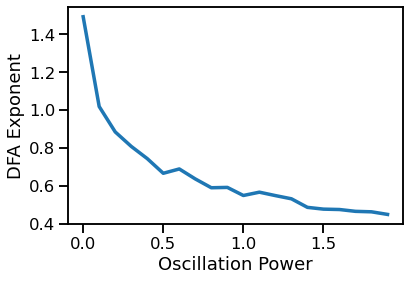

In [32]:
# Plot DFA measures across oscillation power values
plot_lines(POWS, dfa_sims_pow)
plot_lines(xlabel='Oscillation Power', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_osc_power', file_path='dfa')